In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
tf.config.run_functions_eagerly(True)

import os, warnings
warnings.filterwarnings("ignore")

/Users/Santiago/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [4]:
ds_train_ = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [5]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [6]:
model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)


In [9]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=3,
)

Epoch 1/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 957ms/step - binary_accuracy: 0.5854 - loss: 0.6917 - val_binary_accuracy: 0.5785 - val_loss: 0.6894
Epoch 2/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 997ms/step - binary_accuracy: 0.5789 - loss: 0.6886 - val_binary_accuracy: 0.5785 - val_loss: 0.6869
Epoch 3/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - binary_accuracy: 0.5748 - loss: 0.6868 - val_binary_accuracy: 0.5785 - val_loss: 0.6851


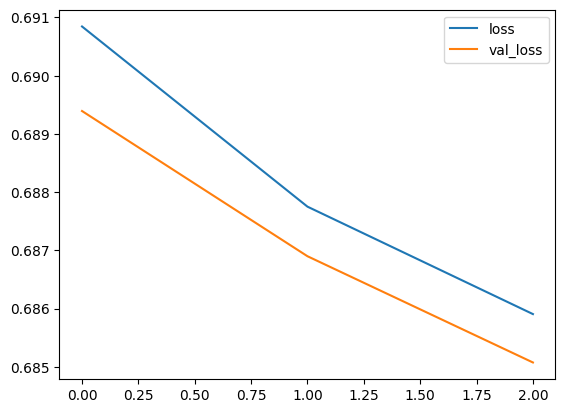

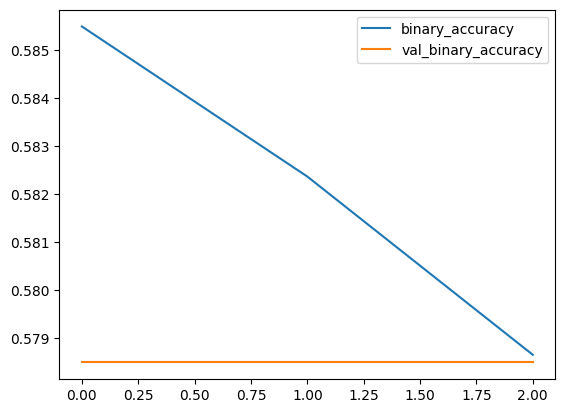

In [10]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The learning curves for the model from the tutorial diverged fairly rapidly. This would indicate that it was prone to overfitting and in need of some regularization. The additional layer in our new model would make it even more prone to overfitting. However, adding some regularization with the Dropout layer helped prevent this. These changes improved the validation accuracy of the model by several points.